Overview
--------
The goal of the codes in this notebooke:
1. get a trained LightGBM, XGBoost, or CatBoost model<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2), import it in an appropriate format (.txt or a dictionary);
2. store the structure of each decision tree from the ensemble in a dictionary called info:

        info.keys()=['depth', 'n_leaves', 'splits', 'distinct_feature_indx', 'regions']
- info['depth']: the depth of the tree;
- info['n_leaves']: the number of leaves;
- info['splits]: a list of all splits happening in the tree recorded in the form of (feature_index,threshold);
- info['distinct_feature_indx']: records indices of distinct features with respect to which splittings occur in the ascending order;
- info['regions'] is a list of dictionaries each describing one of the regions. The keys for each element of info['regions'] are 'value' (the value at the corresponding leaf) and the indices of features which should satisfy non-trivial bounds in the region. E.g. $\{k:[a,b]\}$ meaning in that region the feature $X_k$ is required to be between $a,b$. 

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Versions of these libraries on which this notebook is based: lightgbm.__version__=3.3.2, xgboost.__version__=1.5.2, catboost.__version__=0.21.

<a name="cite_note-1"></a>2. [^](#cite_ref-2) The models here are regressors trained on non-categorical features. 

In [1]:
#Importing boosting libraries
import lightgbm
import xgboost
import catboost

How a LightGBM model is provided to us? 
---------------------------------------
Saving a LightGBM model (called lgr) as a .model file:

                        lgr.booster_.save_model('Regressor_LightGBM.model')
                        
(Also possible to save as a .txt file: https://stackoverflow.com/questions/55208734/save-lgbmregressor-model-from-python-lightgbm-package-to-disc)

Given the .model or .txt file, one can dump the model as a dictionary:

                        lgr = lightgbm.Booster(model_file='Regressor_LightGBM.model')
                        dictionary_lgbm=lgr.dump_model()

In [2]:
#Importing a saved LightGBM model as a dictionary.
#The saved model should be a .model or .txt file. 
lgbm_model_name='Regressor_LightGBM_1'
extension='.model' #Or '.txt' if appropriate. 
lgr = lightgbm.Booster(model_file=lgbm_model_name +extension)
dictionary_lgbm=lgr.dump_model()
print('The keys of the dictionary:',dictionary_lgbm.keys(),'\n')
print('The size of the ensemble is:',len(dictionary_lgbm['tree_info']),'\n')
print('The keys of the dictionary descrribing tree index 0:',dictionary_lgbm['tree_info'][0]['tree_structure'].keys())

The keys of the dictionary: dict_keys(['name', 'version', 'num_class', 'num_tree_per_iteration', 'label_index', 'max_feature_idx', 'objective', 'average_output', 'feature_names', 'monotone_constraints', 'feature_infos', 'tree_info', 'feature_importances', 'pandas_categorical']) 

The size of the ensemble is: 300 

The keys of the dictionary descrribing tree index 0: dict_keys(['split_index', 'split_feature', 'split_gain', 'threshold', 'decision_type', 'default_left', 'missing_type', 'internal_value', 'internal_weight', 'internal_count', 'left_child', 'right_child'])


The Structure of dictionaries describing LightGBM models 
--------------------------------------------------------
The dictionary obtained from dumping a LightGBM model, say dictionary_lgbm, has various keys. 
Information about the trees is stored in 

                        dictionary_lgbm['tree_info']                       
This is a list with one entry for each tree which is a dictionary itself.  We are interested in  

                        dictionary_lgbm['tree_info'][i]['tree_structure']
where the structure of the tree of index $i$ is reflected in a nested dictionary. 

In [3]:
#A minimal example, a tree with one root and two leaves.
dictionary_lgbm['tree_info'][0]['tree_structure']['left_child']['left_child']['right_child']

{'split_index': 19,
 'split_feature': 35,
 'split_gain': 41200,
 'threshold': 1.0960071838733,
 'decision_type': '<=',
 'default_left': True,
 'missing_type': 'None',
 'internal_value': 33.4335,
 'internal_weight': 917,
 'internal_count': 917,
 'left_child': {'leaf_index': 15,
  'leaf_value': 34.46838582825766,
  'leaf_weight': 271,
  'leaf_count': 271},
 'right_child': {'leaf_index': 20,
  'leaf_value': 32.99935009526411,
  'leaf_weight': 646,
  'leaf_count': 646}}

The function retrieve_lgbm
--------------------------
The nested dictionary describing a tree of a LightGBM model, say dictionary_lgbm['tree_info'][0]['tree_structure'], is passed to the function 

                 retrieve_lgbm(tree_structure)
which retrieves the structural information of the tree and returns it as a dictionary called info with the keys 

                 info.keys()=['depth', 'n_leaves', 'splits', 'distinct_feature_indx', 'regions']
as described before.

In [4]:
def retrieve_lgbm(tree_structure):                                                                    
    info={}
    info['depth']=0 
    info['n_leaves']=1
    info['splits']=[]
    info['distinct_feature_indx']=[]
    info['regions']=[]
    
    #A single node is considered to be a tree of depth 0 with just 1 leaf. 
    if 'split_feature' not in tree_structure.keys():
        return info 
    
    #The first splitting happening at the root:
    feature_indx_root=tree_structure['split_feature']
    threshold_root=tree_structure['threshold']
    
    #The left sub-tree branching from the root:
    subtree_left=tree_structure['left_child']
    info_left=retrieve_lgbm(subtree_left)
    
    #The right sub-tree branching from the root: 
    subtree_right=tree_structure['right_child']
    info_right=retrieve_lgbm(subtree_right)
    
    #Computing the depth:
    info['depth']=1+max(info_left['depth'],info_right['depth'])
    
    #Computing the number of leaves:
    info['n_leaves']=info_left['n_leaves']+info_right['n_leaves']
    
    #Recording the splittings:
    info['splits']=[(feature_indx_root,threshold_root)]+info_left['splits']+info_right['splits']
    
    #Recording the indices of the different features appearing in the tree in ascending order:
    for split in info['splits']:
        if split[0] not in info['distinct_feature_indx']:
            info['distinct_feature_indx']+=[split[0]]
    info['distinct_feature_indx'].sort()
    
    #info['regions'] is built recursively via calling the function for left and right subtrees. 
    #One should condition on if the left or right subtree is a single node.
    #Keep in mind that at a node if feature<=threshold, we go to left, otherwise to right. 
    #(We always take inequalities to be strict, the assumption is that feature==threshold is very unlikely.)
    #The auxiliary function modify_interval is used to update a range obtained form a subtree according to the threshold at the root. 
    if info_left['depth']==0 and info_right['depth']==0:
        info['regions']=[{'value':tree_structure['left_child']['leaf_value'],feature_indx_root:[-float('inf'),threshold_root]}
                         ,{'value':tree_structure['right_child']['leaf_value'],feature_indx_root:[threshold_root,float('inf')]}]
    elif info_left['depth']==0 and info_right['depth']!=0:
        info['regions']=[{'value':tree_structure['left_child']['leaf_value'],feature_indx_root:[-float('inf'),threshold_root]}]
        for region in info_right['regions']:
            if feature_indx_root not in region.keys():
                region[feature_indx_root]=[threshold_root,float('inf')]
            else:
                region[feature_indx_root]=modify_interval(region[feature_indx_root],threshold_root,'lower')
        info['regions']+=info_right['regions']        
    elif info_left['depth']!=0 and info_right['depth']==0:
        for region in info_left['regions']:
            if feature_indx_root not in region.keys():
                region[feature_indx_root]=[-float('inf'),threshold_root]
            else:
                region[feature_indx_root]=modify_interval(region[feature_indx_root],threshold_root,'upper')
        info['regions']=info_left['regions']   
        info['regions']+=[{'value':tree_structure['right_child']['leaf_value'],feature_indx_root:[threshold_root,float('inf')]}]
    else:
        for region in info_left['regions']:
            if feature_indx_root not in region.keys():
                region[feature_indx_root]=[-float('inf'),threshold_root]
            elif modify_interval(region[feature_indx_root],threshold_root,'upper')!=None:                  #None means the region is vacuous or degenerate. 
                region[feature_indx_root]=modify_interval(region[feature_indx_root],threshold_root,'upper')
        info['regions']=info_left['regions']
        for region in info_right['regions']:
            if feature_indx_root not in region.keys():
                region[feature_indx_root]=[threshold_root,float('inf')]
            elif modify_interval(region[feature_indx_root],threshold_root,'lower')!=None:                  #None means the region is vacuous or degenerate.
                region[feature_indx_root]=modify_interval(region[feature_indx_root],threshold_root,'lower')
        info['regions']+=info_right['regions']        
    return info
                    
######################################################## Auxiliary Functions #####################################

#Returns the intersection of interval with <=bound when kind=='upper' and with >=bound when kind=='lower'.
#Returns None if the intersection is empty or degenerate. 
def modify_interval(interval,bound,kind):
    if interval==None:                      #Nothing to modify if the interval is empty to begin with. 
        return None
    if kind=='upper':
        if interval[0]>=bound:
            return None
        else:
            interval[1]=min(interval[1],bound)
    else:
        if interval[1]<=bound:
            return None
        else:
            interval[0]=max(interval[0],bound)
    return interval            

In [5]:
#Going back to our minimal example:
retrieve_lgbm(dictionary_lgbm['tree_info'][0]['tree_structure']['left_child']['left_child']['right_child'])

{'depth': 1,
 'n_leaves': 2,
 'splits': [(35, 1.0960071838733)],
 'distinct_feature_indx': [35],
 'regions': [{'value': 34.46838582825766, 35: [-inf, 1.0960071838733]},
  {'value': 32.99935009526411, 35: [1.0960071838733, inf]}]}

How a XGBoost model is provided to us? 
--------------------------------------
Saving a XGBoost model (called xgr) as a .model file:

                        xgr.save_model('Regressor_XGB.model')
                        
Loading a saved XGBoost model:

                        xgr=xgboost.Booster()
                        xgr.load_model('Regressor_XGB.model')
                        
A XGBoost model can be dumped as a .txt or .json file, or as a data frame. <br>
https://stackoverflow.com/questions/50175901/how-to-extract-decision-rules-features-splits-from-xgboost-model-in-python3
https://stackoverflow.com/questions/37677496/how-to-get-access-of-individual-trees-of-a-xgboost-model-in-python-r

It is easier to extract single trees from .txt files.

                        xgr.get_booster().dump_model('Regressor_XGB.txt')

In [6]:
#Importing a saved XGBoost model (a .model file) and dumping it as a text file. 
XGB_model_name='Regressor_XGB_1'
extension='.model'
xgr=xgboost.Booster()
xgr.load_model(XGB_model_name+extension)
xgr.dump_model('Regressor_XGB_1.txt')

#We record the lines of this text file in a list. 
file=open('Regressor_XGB_1.txt','r')
text_xgb=file.readlines()

The Structure of text files describing XGBoost models 
-----------------------------------------------------
In the text file, the description of the tree of index $i$ begins with booster[$i$]. In the part describing a tree of the ensemble:
- each line corresponds to a split or a leaf; 
- the lines are numbered starting from zero and are indented based on depth;
- for a split, the threshold and the line numbers for the children are indicated;
- for leaves, the values are recorded. 

The function 

                         separate_trees(text_xgb)
separates the lines corresponding to each tree and returns a list trees_list each entry of which is a list consisting of the lines of the text_xgb file that describe a tree of the ensemble. 
          
          

In [7]:
#Separating trees:
def separate_trees(text_xgb):
    trees_list=[]
    for line in text_xgb:
        if line[0:7]=='booster':
            trees_list+=[[]]
        else:
            trees_list[-1]+=[line]
    return trees_list

In [8]:
trees_list=separate_trees(text_xgb)
print('The size of the ensemble is:',len(trees_list))

The size of the ensemble is: 300


In [ ]:
#Warning: The output of this cell will be huge. 
#trees_list

In [9]:
#Example: looking at one of the trees
trees_list[0]

#Observe that there is an entry for each node, describing the leaf value if it is a leaf, describing the split otherwise. 
#The depth of a node can be recovered from the number of '\t' characters at the beginning of the line (root being of depth 0).
#For non-leaf nodes, after a string of \t characters, one sees something of the form 'i:[fk<threshold] yes=2m+1,no=2l' where
#k is the index of the feature with respect to which the tree splits. If the value of that feature is less than the threshold, 
#the data instance goes to the line starting with '\t..\t2m+1...', and otherwise to the line starting with '\t...\t2l'.
#Given a line such as '\t..\ti:[fk<threshold] yes=2m+1,no=2l...', we call i the tree index of the corresponding node. 

['0:[f67<399.884216] yes=1,no=2,missing=1\n',
 '\t1:[f31<5725.95801] yes=3,no=4,missing=3\n',
 '\t\t3:[f35<1.08203411] yes=7,no=8,missing=7\n',
 '\t\t\t7:[f2<16.6865082] yes=15,no=16,missing=15\n',
 '\t\t\t\t15:[f76<0.549008131] yes=31,no=32,missing=31\n',
 '\t\t\t\t\t31:[f59<51.3699989] yes=63,no=64,missing=63\n',
 '\t\t\t\t\t\t63:leaf=3.52386951\n',
 '\t\t\t\t\t\t64:leaf=7.7526927\n',
 '\t\t\t\t\t32:[f2<11.7518959] yes=65,no=66,missing=65\n',
 '\t\t\t\t\t\t65:leaf=24.4000015\n',
 '\t\t\t\t\t\t66:leaf=9.58354568\n',
 '\t\t\t\t16:[f55<0.816041112] yes=33,no=34,missing=33\n',
 '\t\t\t\t\t33:[f57<102.759995] yes=67,no=68,missing=67\n',
 '\t\t\t\t\t\t67:leaf=1.7805661\n',
 '\t\t\t\t\t\t68:leaf=4.97975016\n',
 '\t\t\t\t\t34:[f35<0.860243022] yes=69,no=70,missing=69\n',
 '\t\t\t\t\t\t69:leaf=6.65493631\n',
 '\t\t\t\t\t\t70:leaf=3.27707887\n',
 '\t\t\t8:[f35<1.09414339] yes=17,no=18,missing=17\n',
 '\t\t\t\t17:[f7<123.511337] yes=35,no=36,missing=35\n',
 '\t\t\t\t\t35:[f12<760.554993] yes=71

The function retrieve_xgb
-------------------------
The list of strings describing a tree of a XGBoost model, say trees_list[0], is passed to the function 

                 retrieve_xgb(tree_list)
which retrieves the structural information of the tree and returns it as a dictionary called info with keys

                 info.keys()=['depth', 'n_leaves', 'splits', 'distinct_feature_indx', 'regions']
as described before. 

In [10]:
# Input a tree in the form of tree_list (e.g. an entry from trees_list) which is 
#a list of strings read from the .txt file describing the XGBoost model (each entry a line from the .txt file). 

def retrieve_xgb(tree_list):                                                                    
    info={}
    info['depth']=compute_depth(tree_list) 
    info['splits']=extract_splits(tree_list)
    info['distinct_feature_indx']=distinct_features(tree_list)
    info['regions']=extract_regions(tree_list)
    info['n_leaves']=len(info['regions'])
    
    return info
    
######################################################## Auxiliary Functions ###############################################

#Each line of the .txt file, i.e. an entry of tree_list, describes a node of the tree under consideration (leaf or non-leaf). 
#The line starts like '\t...\ti:' where the number of '\t' characters is the depth (root being of depth 0) and i is the tree index. 
#Children of a non-leaf node have tree indices 2m+1 and 2l with the odd index for the case of <threshold and the even for >threshold. 
#The function depth_index computes the depth of a node as well as its tree index.  
def depth_index(string):
    temp=string.split(':')
    temp=temp[0]                   #This is a sequence of '\t' characters followed by an integer. 
    depth=0
    while True:
        if temp[0]=='\t':
            depth+=1
            temp=temp[1:]
        else:
            tree_index=int(temp)
            break
    return (depth,tree_index)        

#The previous function is invoked to compute the depth of a tree by going over all corresponding lines of the .txt file.     
def compute_depth(tree_list):
    depth=0
    for line in tree_list:
        depth=max(depth,depth_index(line)[0])
    return depth

############

#Extracts the splits occuring in a tree and returns them in as a list of tuples (feature_index,threshold). 
def extract_threshold(string):
    temp=string.split('[')
    temp=temp[1].split(']')[0]       #This would be of the form say 'f8<36.8828926'. 
    temp=temp.split('<')
    feature_index=int(temp[0][1:])   #temp[0] is something like 'f8'.
    threshold=float(temp[1])         #temp[1] is something like '36.8828926'.
    return (feature_index,threshold)

#The previous function is called to extract all the splits of a tree by going over all corresponding lines of the .txt file.  
def extract_splits(tree_list):
    splits_list=[]
    for line in tree_list:
        temp=line.split('[')
        if len(temp)==1:                     #This corresponds to the case when the line describes a leaf. 
            continue
        else:  
            splits_list+=[extract_threshold(line)]
    return splits_list

#The output of the function extract_splits above is used to record the different features pertinent to a tree 
#as a list of ascending integers. 
def distinct_features(tree_list):
    features_list=[]
    splits_list=extract_splits(tree_list)
    for split in splits_list:                #split=(feature_index,threshold)
        if split[0] not in features_list:
            features_list+=[split[0]]
    features_list.sort()
    return features_list
    
############

#Extracting regions: the function first detects leaves and then adds the corresponding region to our list. 
#The auxiliary function partial_region is called to obtain the region corresponding to a leaf. 
def extract_regions(tree_list):
    regions_list=[]
    for i in range(len(tree_list)):
        line=tree_list[i]
        temp=line.split('[')
        if len(temp)>1:                        #This means '[' appears in the line and hence the node is not a leaf. 
            continue
        temp=line.split(':leaf=')
        value=float(temp[1].split('\n')[0])
        region=partial_region(tree_list,i)     
        region['value']=value
        regions_list+=[region]   
    return regions_list
                    
#Given a tree (a list of strings capturing the lines of the .txt file describing to a tree) and a line_number,
#the function below returns the region determined before reaching the node corresponding to that line from the root. 
def partial_region(tree_list,line_number):                                   
    line=tree_list[line_number]
    tree_index=depth_index(line)[1]
    if tree_index==0:                                          
        return {} 
                                                             #We next find the parent node (the function is recursive).
    if tree_index%2==0:                                      #tree_index even means that feature value>threshold for the last split.                            
        for j in range(line_number-1,-1,-1):                 #j is used for scanning the lines before (tree_list[i] with i<line_number).
            temp=tree_list[j]
            if len(temp.split('no='+str(tree_index)+','))>1:
                parent_index=depth_index(tree_list[j])[1]
                break
    else:                                                    #tree_index odd means that feature value<threshold for the last split.
        for j in range(line_number-1,-1,-1):
            temp=tree_list[j]
            if len(temp.split('yes='+str(tree_index)+','))>1:
                parent_index=depth_index(tree_list[j])[1]
                break   
                                                               
    for j in range(line_number-1,-1,-1):                                
        line=tree_list[j]
        if depth_index(line)[1]==parent_index:                #The line describing the parent node detected. 
            (feature_index,threshold)=extract_threshold(line) #The splitting at the parent node is captured.
            region=partial_region(tree_list,j) 
                                                              #Modifying the region corresponding to the parent via
            if feature_index not in region.keys():            #incorporating the aforementione threshold.  
                if tree_index%2==0:                           
                    region[feature_index]=[threshold, float('inf')]
                else:
                    region[feature_index]=[-float('inf'),threshold]
            else:
                if tree_index%2==0 and modify_interval(region[feature_index],threshold,'lower')!=None:   #None means the region is vacuous or degenerate.
                    region[feature_index]=modify_interval(region[feature_index],threshold,'lower')
                elif tree_index%2==1 and modify_interval(region[feature_index],threshold,'upper')!=None: #None means the region is vacuous or degenerate.
                    region[feature_index]=modify_interval(region[feature_index],threshold,'upper')
            break
    return region

############

#This function appeared before. 
def modify_interval(interval,bound,kind):
    if interval==None:                      #Nothing to modify if the interval is empty to begin with. 
        return None
    if kind=='upper':
        if interval[0]>=bound:
            return None
        else:
            interval[1]=min(interval[1],bound)
    else:
        if interval[1]<=bound:
            return None
        else:
            interval[0]=max(interval[0],bound)
    return interval            

In [11]:
#Example
retrieve_xgb(trees_list[15])

{'depth': 6,
 'splits': [(74, 2.12592554),
  (44, 92.3953323),
  (59, 4.26964998),
  (20, 350.357849),
  (58, 2.9632256),
  (48, 76.9389877),
  (20, 343.77832),
  (5, 1.39872885),
  (22, 104.536911),
  (48, 76.0374985),
  (72, 2.08112335),
  (74, 2.06607246),
  (3, 66.8522873),
  (12, 988.615173),
  (30, 80.8805847),
  (44, 91.127327),
  (76, 1.2990489),
  (20, 340.146454),
  (65, 0.300521553),
  (70, 171.035248),
  (5, 1.16595221),
  (28, 23.2999992),
  (50, 46.6766701),
  (21, 173.350006),
  (6, 1.22364354),
  (16, 0.883287311),
  (0, 4.5),
  (36, 0.884199858),
  (49, 50.1962662),
  (12, 1001.84656),
  (16, 1.22455335),
  (72, 2.25435972),
  (45, 1.55063128),
  (6, 1.55887866),
  (20, 255.484344),
  (50, 48.598793),
  (34, 1720.1134),
  (50, 51.0927429),
  (26, 1.56622565),
  (23, 148.780121),
  (76, 1.44371653),
  (1, 93.2323303),
  (76, 1.61929595),
  (14, 941.289429),
  (2, 61.9739227),
  (75, 1.8713032),
  (55, 1.60514712),
  (68, 142.675018),
  (74, 2.22771478),
  (72, 2.3150377

How a CatBoost model is provided to us? 
---------------------------------------
Saving a CatBoost model (called cbr) as a .model file:

                        cbr.save_model('Regressor_CatBoost',format='json')
                        
(Also possible to save as a .model file.)

Given the .json file, one can dump the model as a dictionary: 
(Also possible to load the model as a CatBoost classifier or Regressor: https://stackoverflow.com/questions/51895761/how-to-correctly-load-pretrained-model-in-catboost-in-python)

                        cbr=open('Regressor_CatBoost')
                        dictionary_catboost=json.load(cbr)

In [12]:
#Importing a saved CatBoost model (a .model file) and dumping it as a dictionary. 
#(The code would be shorter if the model is provided as a .json file.)
from catboost import CatBoostRegressor
import json

CatBoost_model_name='Regressor_CatBoost_1'
extension='.model'
cbr=CatBoostRegressor()
cbr.load_model(CatBoost_model_name+extension)
cbr.save_model('Regressor_CatBoost',format='json')
cbr=open('Regressor_CatBoost')
dictionary_catboost=json.load(cbr)

print('The keys of the dictionary:',dictionary_catboost.keys(),'\n')
print('The size of the ensemble is:',len(dictionary_catboost['oblivious_trees']),'\n')
print('The keys of the dictionary descrribing tree index 0:',dictionary_catboost['oblivious_trees'][0].keys())

The keys of the dictionary: dict_keys(['features_info', 'model_info', 'oblivious_trees', 'scale_and_bias']) 

The size of the ensemble is: 300 

The keys of the dictionary descrribing tree index 0: dict_keys(['leaf_values', 'leaf_weights', 'splits'])


The Structure of dictionaries describing CatBoost models 
--------------------------------------------------------
The dictionary obtained from dumping a CatBoost model, say dictionary_catboost, has various keys. 
Information about the trees is stored in 

                        dictionary_catboost['oblivious_trees']                       
This is a list with one entry for each tree which is a dictionary itself  

                        dictionary_catboost['oblivious_trees'][i].keys()
                        =['leaf_values', 'leaf_weights', 'splits']
Trees in a CatBoost model are oblivious. So we just need to record one splits per level. This is where 

                        dictionary_catboost['oblivious_trees'][i]['splits']
is used, the list of all splits taking place in the tree (one per level); for each the feature index and the threshold may be recovered. The list is bottom-up, the splits closer to the root come at the end. 

(Detailed guides on extracting internal parameters of saved CatBoost models: 
http://parasmalik.blogspot.com/2020/
https://colab.research.google.com/github/catboost/tutorials/blob/master/model_analysis/model_export_as_json_tutorial.ipynb)

In [13]:
#Example (Notice that a feature may come up more than once which will definitely cause in empty regions.)
dictionary_catboost['oblivious_trees'][178]['splits']

[{'border': 1.0393215417861938,
  'float_feature_index': 16,
  'split_index': 368,
  'split_type': 'FloatFeature'},
 {'border': 1.0427782535552979,
  'float_feature_index': 16,
  'split_index': 369,
  'split_type': 'FloatFeature'},
 {'border': 946.6575927734375,
  'float_feature_index': 14,
  'split_index': 337,
  'split_type': 'FloatFeature'},
 {'border': 945.2777099609375,
  'float_feature_index': 14,
  'split_index': 335,
  'split_type': 'FloatFeature'},
 {'border': 13.180000305175781,
  'float_feature_index': 57,
  'split_index': 1321,
  'split_type': 'FloatFeature'},
 {'border': 1.2957968711853027,
  'float_feature_index': 54,
  'split_index': 1241,
  'split_type': 'FloatFeature'},
 {'border': 74.19512939453125,
  'float_feature_index': 34,
  'split_index': 808,
  'split_type': 'FloatFeature'},
 {'border': 76.81771850585938,
  'float_feature_index': 30,
  'split_index': 701,
  'split_type': 'FloatFeature'}]

The function retrieve_catboost
-------------------------------
A dictionary describing a tree of a CatBoost model, say dictionary_catboost['oblivious_trees'][0], is passed to the function 

                 retrieve_catboost(tree_structure)
which retrieves the structural information of the tree and returns it as a dictionary called info with keys

                 info.keys()=['depth', 'n_leaves', 'splits', 'distinct_feature_indx', 'regions']
as described before. 

In [14]:
#The input tree_structure is a dictionary with keys 'leaf_values', 'leaf_weights' and 'splits'. 
#The codes is considerably easier since the tree is oblivious. 

def retrieve_catboost(tree_structure):
    #Initializing the dictionary:
    info={}
    
    #The first two keys are easy:
    info['depth']=len(tree_structure['splits'])
    info['n_leaves']=2**info['depth']
    
    #Initializing the next two keys:
    info['splits']=[]
    info['distinct_feature_indx']=[]
    
    for split in tree_structure['splits']:               #Each element of tree_structure['splits'] describes a splitting that takes place across an entire level.
        if split['float_feature_index'] not in info['distinct_feature_indx']:
            info['distinct_feature_indx']+=[split['float_feature_index']]
        info['splits']+=[(split['float_feature_index'],split['border'])]
        
    
    #It remains to compute info['region'], a list comprised of one dictionary per region. 
    #Initializing:
    info['regions']=[]
    
    for i in range(2**info['depth']):
        #Constructing the dictionary describing this region:
        region={}
        region['value']=tree_structure['leaf_values'][i]
        
        #Initializing the keys that describe bounds for each feature.
        for feature_index in info['distinct_feature_indx']:
            region[feature_index]=[-float('inf'),float('inf')]
            
        expansion="{0:b}".format(i)                          #The binary expansion of i which is the index of the leaf/region under consideration.
        while len(expansion)<info['depth']:                  #(An integer from [0,2**depth-1], we want len(expansion)=depth.) 
            expansion='0'+expansion
                                                             
        for j in range(info['depth']):                       #The leftmost characters of the expansion are determined by top splits near 
            feature_index=info['splits'][-j-1][0]            #the root which are encoded by the rightmost entries of info['splits'].         
            threshold=info['splits'][-j-1][1]                #(Keep in mind that splits closer to the root appear at the end of tree_structure['splits']).
            
            if expansion[j]=='0':                            #Meaning we go to the left since feature_value<threshold.
                region[feature_index]=modify_interval(region[feature_index],threshold,'upper')
            else:                                            #Meaning we go to the left since feature_value>threshold.
                region[feature_index]=modify_interval(region[feature_index],threshold,'lower')
        
        #Adding the dictionary constructed for this region to info['regions'].
        info['regions']+=[region]
    
    return info

############

#This function appeared before. 
def modify_interval(interval,bound,kind):
    if interval==None:                      #Nothing to modify if the interval is empty to begin with. 
        return None
    if kind=='upper':
        if interval[0]>=bound:
            return None
        else:
            interval[1]=min(interval[1],bound)
    else:
        if interval[1]<=bound:
            return None
        else:
            interval[0]=max(interval[0],bound)
    return interval            

In [18]:
#Example: CatBoost has a built in method for computing the leaf index. 
#For a sample point from an arbitrarily chosen region obtained from retrieve_catboost, the leaf index obtained from CatBoost must match region's index.


import numpy as np
import random

cbr=CatBoostRegressor()
cbr.load_model(CatBoost_model_name+extension)

tree_index=random.randint(0,len(dictionary_catboost['oblivious_trees'])-1)
info=retrieve_catboost(dictionary_catboost['oblivious_trees'][tree_index])
depth=info['depth']
region_index=random.randint(0,2**depth-1)
region=info['regions'][region_index]
print('We are looking at region index %d of tree index %d of the ensemble: '%(region_index,tree_index))
print(region)

not_vacuous=True
for key in region.keys():
    if region[key]==None:
        not_vacuous=False
        print('This region is empty, run the code again.')
        
        
if not_vacuous:
    #Picking a data point from that region: 
    data_instance=np.zeros([1,81])                                #(81 is the number of variables of the models)
    for key in region:
        if key=='value':
            continue
        if region[key][0]==-float('inf'):
            data_instance[0][key]=region[key][1]-1
        elif region[key][1]==float('inf'):
            data_instance[0][key]=region[key][0]+1
        else:
            data_instance[0][key]=0.5*(region[key][0]+region[key][1])
    print('The region index based on a built-in method of CatBoost is:',cbr.calc_leaf_indexes(data_instance)[0][tree_index])



We are looking at region index 53 of tree index 102 of the ensemble: 
{'value': 0, 80: [1.817110538482666, inf], 9: [-inf, 32.85942840576172], 61: [-inf, 60.87832260131836], 70: [72.17550659179688, inf], 3: [56.250579833984375, inf], 6: [-inf, 1.423811674118042], 38: [-inf, 1870.615966796875]}
The region index based on a built-in method of CatBoost is: 53


Visualizing the trees
---------------------
It is possible to visualize the trees to double check the functions introduced here. 

For LightGBM) 

                    lgbm_model_name='Regressor_LightGBM'
                    extension='.model'
                    
                    lgr = lightgbm.Booster(model_file=lgbm_model_name +extension)
                    lightgbm.plot_tree(lgr,tree_index=3,figsize=(100,100))
                    #Looking at tree index 3.
                    
                    
For XGBoost)

                    XGB_model_name='Regressor_XGB'
                    extension='.model'
                    xgr=xgboost.Booster()
                    xgr.load_model(XGB_model_name+extension)
                    
                    from xgboost import plot_tree
                    import matplotlib.pyplot as plt
                    fig, ax = plt.subplots(figsize=(100, 200))
                    plot_tree(xgr, num_trees=4, ax=ax)                            
                    plt.show()
                    #Looking at tree index 4.
                    
For CatBoost) 

                    cbr.plot_tree(tree_idx=0)

The goal of the next few cells is to visualize the parsed ensembles and recover numbers such as average tree depth, average number of distinct features per tree etc. This is done here for the first triple of models. For the second set of models, set 

                                lgbm_model_name='Regressor_LightGBM_2'
                                XGB_model_name='Regressor_XGB_2'
                                CatBoost_model_name='Regressor_CatBoost_2'
in appropriate cells above. Also in next cell one should have

                                n_features=40

In [19]:
import matplotlib.pyplot as plt
n_features=81

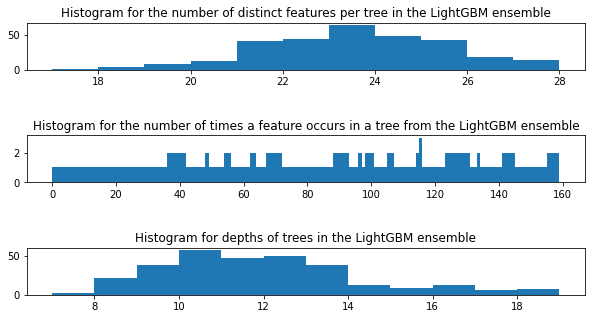

Size of the ensemble: 300
Number of leaves across the ensemble: [31]
The average number of distinct features per tree in the LightGBM ensemble: 23.08
The average number of times a feature comes up a tree from the LightGBM ensemble: 85.45
The average depth of a tree from the LightGBM ensemble: 11.47


In [20]:
tree_structures=[]
n_trees=len(dictionary_lgbm['tree_info'])
for i in range(0,n_trees):
            tree_structures+=[retrieve_lgbm(dictionary_lgbm['tree_info'][i]['tree_structure'])]

feature_occurrences=[]
for i in range(1,n_features+1):
    feature_occurrences+=[0]
    for info in tree_structures:
        if i in info['distinct_feature_indx']:
            feature_occurrences[i-1]+=1

n_distinct_features=[]
n_leaves=[]
depths=[]
for info in tree_structures:
    n_distinct_features+=[len(info['distinct_feature_indx'])]
    n_leaves+=[info['n_leaves']]
    depths+=[info['depth']]
    

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,3)
ax3=fig.add_subplot(5,1,5)

ax1.hist(n_distinct_features,bins=np.unique(np.array(n_distinct_features)))
ax1.locator_params(axis='x', integer=True)
ax1.set_title('Histogram for the number of distinct features per tree in the LightGBM ensemble')
#plt.ylabel('Number of trees')

ax2.hist(feature_occurrences,bins=np.unique(np.array(feature_occurrences)))
ax2.locator_params(axis='x', integer=True)
#plt.xlabel('Number of trees of the LightGBM ensemble in which a feature appears')
ax2.set_title('Histogram for the number of times a feature occurs in a tree from the LightGBM ensemble')

ax3.hist(depths,bins=np.unique(np.array(depths)))
ax3.locator_params(axis='x',integer=True)
ax3.set_title('Histogram for depths of trees in the LightGBM ensemble')

plt.show()

#Having integers on the horizontal axis of the histogram: 
#https://stackoverflow.com/questions/54771089/how-do-i-set-histogram-axis-to-always-be-an-integer

print('Size of the ensemble:',n_trees)

print('Number of leaves across the ensemble:',
      np.unique(np.array(n_leaves)))

print('The average number of distinct features per tree in the LightGBM ensemble:',
      int(100*np.array(n_distinct_features).sum()/len(n_distinct_features))/100)

print('The average number of times a feature comes up a tree from the LightGBM ensemble:',
     int(100*np.array(feature_occurrences).mean())/100)

print('The average depth of a tree from the LightGBM ensemble:',
     int(100*np.array(depths).mean())/100)


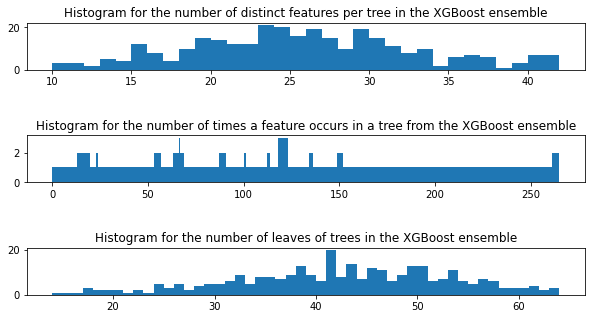

Size of the ensemble: 300
The average number of leaves of a tree from the ensemble: 42.21
The average number of distinct features per tree in the XGBoost ensemble: 25.02
The average number of times a feature comes up a tree from the XGBoost ensemble: 90.29
Depth of trees across the ensemble: [6]


In [21]:
tree_structures=[]
n_trees=len(trees_list)
for i in range(0,n_trees):
            tree_structures+=[retrieve_xgb(trees_list[i])]

feature_occurrences=[]
for i in range(1,n_features+1):
    feature_occurrences+=[0]
    for info in tree_structures:
        if i in info['distinct_feature_indx']:
            feature_occurrences[i-1]+=1

n_distinct_features=[]
n_leaves=[]
depths=[]
for info in tree_structures:
    n_distinct_features+=[len(info['distinct_feature_indx'])]
    n_leaves+=[info['n_leaves']]
    depths+=[info['depth']]
    

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,3)
ax3=fig.add_subplot(5,1,5)

ax1.hist(n_distinct_features,bins=np.unique(np.array(n_distinct_features)))
ax1.locator_params(axis='x', integer=True)
ax1.set_title('Histogram for the number of distinct features per tree in the XGBoost ensemble')
#plt.ylabel('Number of trees')

ax2.hist(feature_occurrences,bins=np.unique(np.array(feature_occurrences)))
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of times a feature occurs in a tree from the XGBoost ensemble')

ax3.hist(n_leaves,bins=np.unique(np.array(n_leaves)))
ax3.locator_params(axis='x',integer=True)
ax3.set_title('Histogram for the number of leaves of trees in the XGBoost ensemble')

plt.show()

#Having integers on the horizontal axis of the histogram: 
#https://stackoverflow.com/questions/54771089/how-do-i-set-histogram-axis-to-always-be-an-integer

print('Size of the ensemble:',n_trees)

print('The average number of leaves of a tree from the ensemble:',
      int(100*np.array(n_leaves).mean())/100)

print('The average number of distinct features per tree in the XGBoost ensemble:',
      int(100*np.array(n_distinct_features).sum()/len(n_distinct_features))/100)

print('The average number of times a feature comes up a tree from the XGBoost ensemble:',
     int(100*np.array(feature_occurrences).mean())/100)

print('Depth of trees across the ensemble:',
     np.unique(np.array(depths)))


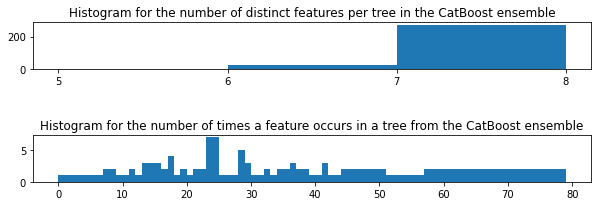

Size of the ensemble: 300
Number of leaves across the ensemble: [256]
The average number of distinct features per tree in the CatBoost ensemble: 7.48
The average number of times a feature comes up a tree from the CatBoost ensemble: 27.67
Depths of trees across the ensemble: [8]


In [22]:
tree_structures=[]
n_trees=len(dictionary_catboost['oblivious_trees'])
for i in range(0,n_trees):
            tree_structures+=[retrieve_catboost(dictionary_catboost['oblivious_trees'][i])]

feature_occurrences=[]
for i in range(1,n_features+1):
    feature_occurrences+=[0]
    for info in tree_structures:
        if i in info['distinct_feature_indx']:
            feature_occurrences[i-1]+=1

n_distinct_features=[]
n_leaves=[]
depths=[]
for info in tree_structures:
    n_distinct_features+=[len(info['distinct_feature_indx'])]
    n_leaves+=[info['n_leaves']]
    depths+=[info['depth']]
    

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,3)
#ax3=fig.add_subplot(5,1,5)

ax1.hist(n_distinct_features,bins=np.unique(np.array(n_distinct_features)))
ax1.locator_params(axis='x', integer=True)
ax1.set_title('Histogram for the number of distinct features per tree in the CatBoost ensemble')
#plt.ylabel('Number of trees')

ax2.hist(feature_occurrences,bins=np.unique(np.array(feature_occurrences)))
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of times a feature occurs in a tree from the CatBoost ensemble')

# ax3.hist(n_leaves,bins=np.unique(np.array(n_leaves)))
# ax3.locator_params(axis='x',integer=True)
# ax3.set_title('Histogram for the number of leaves of trees in the XGBoost ensemble')

plt.show()

#Having integers on the horizontal axis of the histogram: 
#https://stackoverflow.com/questions/54771089/how-do-i-set-histogram-axis-to-always-be-an-integer

print('Size of the ensemble:',n_trees)

print('Number of leaves across the ensemble:',
      np.unique(np.array(n_leaves)))

print('The average number of distinct features per tree in the CatBoost ensemble:',
      int(100*np.array(n_distinct_features).sum()/len(n_distinct_features))/100)

print('The average number of times a feature comes up a tree from the CatBoost ensemble:',
     int(100*np.array(feature_occurrences).mean())/100)

print('Depths of trees across the ensemble:',
     np.unique(np.array(depths)))
